In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from obspy.io.segy.segy import _read_segy
import matplotlib.ticker as ticker
from scipy.interpolate import griddata

In [7]:
# Load data
dfs = pd.read_excel('../data/2022_Gravity_Corrected.xlsx', sheet_name=None)
group5_df1 = dfs['GROUP5 CG5-1']
group5_df2 = dfs['GROUP5 CG5-2']
group1_df = dfs['GROUP1 CG5-2']

# Combine Group 5 DataFrames
group5_combined = pd.concat([group5_df1, group5_df2], ignore_index=True)

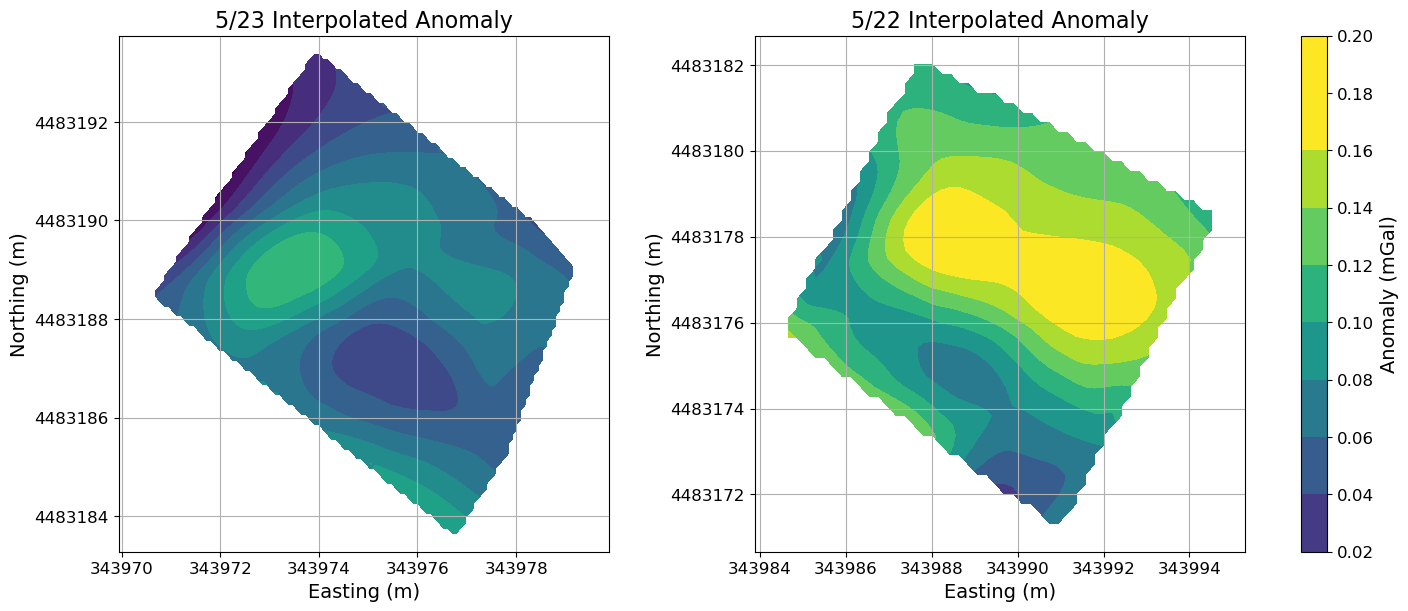

In [10]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# Font sizes
title_fs = 16
label_fs = 14
tick_fs = 12
cbar_fs = 14

# --- Group 1 (Left Plot) ---
x2 = group1_plot['Easting (m)']
y2 = group1_plot['Northing (m)']
z2 = group1_plot['normalized']
xi2 = np.linspace(x2.min(), x2.max(), 100)
yi2 = np.linspace(y2.min(), y2.max(), 100)
xi2, yi2 = np.meshgrid(xi2, yi2)
zi2 = griddata((x2, y2), z2, (xi2, yi2), method='cubic')

c1 = axs[0].contourf(xi2, yi2, zi2, levels=8, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title("5/23 Interpolated Anomaly", fontsize=title_fs)
axs[0].set_xlabel("Easting (m)", fontsize=label_fs)
axs[0].set_ylabel("Northing (m)", fontsize=label_fs)
axs[0].tick_params(labelsize=tick_fs)
axs[0].axis('equal')
axs[0].grid(True)
axs[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))
axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:.0f}"))

# --- Group 5 (Right Plot) ---
x1 = group5_plot['Easting (m)']
y1 = group5_plot['Northing (m)']
z1 = group5_plot['normalized']
xi1 = np.linspace(x1.min(), x1.max(), 50)
yi1 = np.linspace(y1.min(), y1.max(), 50)
xi1, yi1 = np.meshgrid(xi1, yi1)
zi1 = griddata((x1, y1), z1, (xi1, yi1), method='cubic')

c2 = axs[1].contourf(xi1, yi1, zi1, levels=8, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title("5/22 Interpolated Anomaly", fontsize=title_fs)
axs[1].set_xlabel("Easting (m)", fontsize=label_fs)
axs[1].set_ylabel("Northing (m)", fontsize=label_fs)
axs[1].tick_params(labelsize=tick_fs)
axs[1].axis('equal')
axs[1].grid(True)
axs[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:.0f}"))

# Shared colorbar
cbar = fig.colorbar(c2, ax=axs, location='right')
cbar.set_label('Anomaly (mGal)', fontsize=cbar_fs)
cbar.ax.tick_params(labelsize=tick_fs)

plt.savefig("../figures/interpolated_grav_anomaly")
plt.show()
